---
title: "Understanding the biology of diseases"
author: "Saikat Banerjee"
format:
  html: default
date: "2024-03-18"
file-modified: "2024-06-10"
abstract: "We attempt to characterize the biology of diseases from the low dimensional representation of the PanUKB summary statistics."

---

In [1]:
import os
import re
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from adjustText import adjust_text
import textalloc

from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')
from matplotlib.gridspec import GridSpec

import sys
sys.path.append("../utils/")
import simulate as mpy_simulate

In [2]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
result_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/results/nnsparsh/noRx"
# h2_cut = 0.1
# pval_cut = 5e-8

zscore_df = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_noRx.pkl"))
# trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_noRx.pkl"))
trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_all_with_desc.pkl"))

variant_filename = f"{data_dir}/allvar.pruned.closesttss.hugo"
variant_df = pd.read_csv(variant_filename, sep = '\t')

In [3]:
# def compute_cos(xmat):
#     xstd  = xmat / np.sqrt(np.var(xmat, axis = 1, keepdims = True))
#     xstd2 = xstd ** 2
#     return xstd2 / np.sum(xstd2, axis = 1, keepdims = True)

# def compute_contribution(xmat):
#     xstd  = xmat / np.sqrt(np.var(xmat, axis = 0, keepdims = True))
#     xstd2 = xstd ** 2
#     return xstd2 / np.sum(xstd2, axis = 0, keepdims = True)

# def compute_contribution(factor):
#     return (factor ** 2) / (np.sum(factor ** 2, axis = 0).reshape((1, factor.shape[1])))

# def compute_cos(factor):
#     return (factor ** 2) / (np.sum(factor ** 2, axis = 1).reshape((factor.shape[0], 1)))

def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    loadings = U @ np.diag(S)
    factors  = Vt.T
    return U, S, loadings, factors

def compute_cos(xmat):
    xmat2 = xmat ** 2
    return xmat2 / np.sum(xmat2, axis = 1, keepdims = True)

def compute_contribution(xmat):
    xmat2 = xmat ** 2
    return xmat2 / np.sum(xmat2, axis = 0, keepdims = True)

In [4]:
method = 'rpca'
res_filename = os.path.join(result_dir, f"{method}_model.pkl")
with (open(res_filename, "rb")) as fh:
    lowrank_model = pickle.load(fh)

In [5]:
lowrank_model.keys()

dict_keys(['rho_', 'max_iter_', 'mu_update_method_', 'tau_', 'primal_tol_', 'dual_tol_', 'prog_step_skip_', 'show_progress_', 'is_debug_', 'is_benchmark_', 'benchmark_method_', 'mask_', 'mu_list_', 'primal_res_', 'dual_res_', 'cpu_time_', 'L_', 'E_'])

In [6]:
U, S, loadings, factors = get_principal_components(lowrank_model['L_'])
cos2_pheno   = compute_cos(loadings)
cos2_variant = compute_cos(factors)
contribution_pheno   = compute_contribution(loadings)
contribution_variant = compute_contribution(factors)
# cos2_pheno = get_cos2_scores(loadings)
# contribution_pheno = get_contribution_scores(loadings)

# List of phenotypes

In [7]:
pheno_zindex = [int(x[1:]) for x in zscore_df.columns]
trait_df_noRx = trait_df.loc[trait_df['zindex'].isin(pheno_zindex)]
trait_df_noRx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2110 entries, 0 to 2482
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   zindex                       2110 non-null   int64  
 1   trait_type                   2110 non-null   object 
 2   phenocode                    2110 non-null   object 
 3   pheno_sex                    2110 non-null   object 
 4   coding                       267 non-null    object 
 5   modifier                     394 non-null    object 
 6   description                  2110 non-null   object 
 7   description_more             1408 non-null   object 
 8   coding_description           261 non-null    object 
 9   category                     2072 non-null   object 
 10  BIN_QT                       2110 non-null   object 
 11  n_cases_EUR                  2110 non-null   int64  
 12  n_controls_EUR               1304 non-null   float64
 13  N                      

In [8]:
trait_df_noRx['description'].to_list()

['A04 Other bacterial intestinal infections',
 'A08 Viral and other specified intestinal infections',
 'A09 Diarrhoea and gastro-enteritis of presumed infectious origin',
 'A41 Other septicaemia',
 'B34 Viral infection of unspecified site',
 'B37 Candidiasis',
 'B95 Streptococcus and staphylococcus as the cause of diseases classified to other chapters',
 'B96 Other bacterial agents as the cause of diseases classified to other chapters',
 'B98 Other specified infectious agents as the cause of diseases classified to other chapters',
 'C18 Malignant neoplasm of colon',
 'C34 Malignant neoplasm of bronchus and lung',
 'C43 Malignant melanoma of skin',
 'C44 Other malignant neoplasms of skin',
 'C50 Malignant neoplasm of breast',
 'C54 Malignant neoplasm of corpus uteri',
 'C67 Malignant neoplasm of bladder',
 'C77 Secondary and unspecified malignant neoplasm of lymph nodes',
 'C78 Secondary malignant neoplasm of respiratory and digestive organs',
 'C79 Secondary malignant neoplasm of other

In [9]:
focal_disease = {
    "opentarget_name": "triglyceride",
    "opentarget_id": "EFO_0004530",
    "df_query_string": "Triglycerides",
}

# focal_disease = {
#     "opentarget_name": "",
#     "opentarget_id": "",
#     "df_query_string": "Body mass index (BMI)",
# }

# focal_disease = {
#     "opentarget_name": "arthritis",
#     "opentarget_id": "HP_0001370",
#     "df_query_string": "Rheumatoid arthritis",
# }

# focal_disease = {
#     "opentarget_name": "breast",
#     "opentarget_id": "EFO_0003869",
#     "df_query_string": "Breast cancer",
# }

# focal_disease = {
#     "opentarget_name": "",
#     "opentarget_id": "",
#     "df_query_string": "Colon cancer",
# }


# trait_df_noRx.query("description == 'Body mass index (BMI)'")
trait_df_noRx.query(f"description == '{focal_disease['df_query_string']}'")
# trait_df_noRx.query("description == 'Systolic blood pressure, combined automated + manual reading, adjusted by medication'")
# trait_df_noRx.query("description == 'Rheumatoid arthritis'")
# trait_df_noRx.query("description == 'Breast cancer'")
# trait_df_noRx.query("description == 'Cancer of prostate'")



,zindex,trait_type,phenocode,pheno_sex,coding,modifier,description,description_more,coding_description,category,BIN_QT,n_cases_EUR,n_controls_EUR,N,Neff,filename,aws_link,estimates.final.h2_observed,long_description,short_description
1704,1705,biomarkers,30870,both_sexes,NaN,irnt,Triglycerides,NaN,NaN,Biological samples > Assay results > Blood ass...,QT,400639,NaN,400639,400639.0,biomarkers-30870-both_sexes-irnt.tsv.bgz,https://pan-ukb-us-east-1.s3.amazonaws.com/sum...,0.177,Triglycerides,Triglycerides


In [10]:
zindex = 1705

trait_indices = np.array(trait_df_noRx.index)
tidx = np.searchsorted(trait_indices, zindex - 1)

top_factor = np.argsort(cos2_pheno[tidx,:])[::-1][0]
# top_factor_score = cos2_pheno[tidx, top_factor]
top_traits_idx = np.argsort(contribution_pheno[:,top_factor])[::-1]
top_traits_name = trait_df_noRx.loc[trait_indices[top_traits_idx]]['short_description'].to_list()
top_traits_score = contribution_pheno[top_traits_idx, top_factor]

top_variant_idx = np.argsort(contribution_variant[:, top_factor])[::-1][:20]
top_variant_df = variant_df.loc[zscore_df.index.to_numpy()[top_variant_idx]]
top_variant_score = contribution_variant[top_variant_idx, top_factor]

# Importance of factors for the focal trait

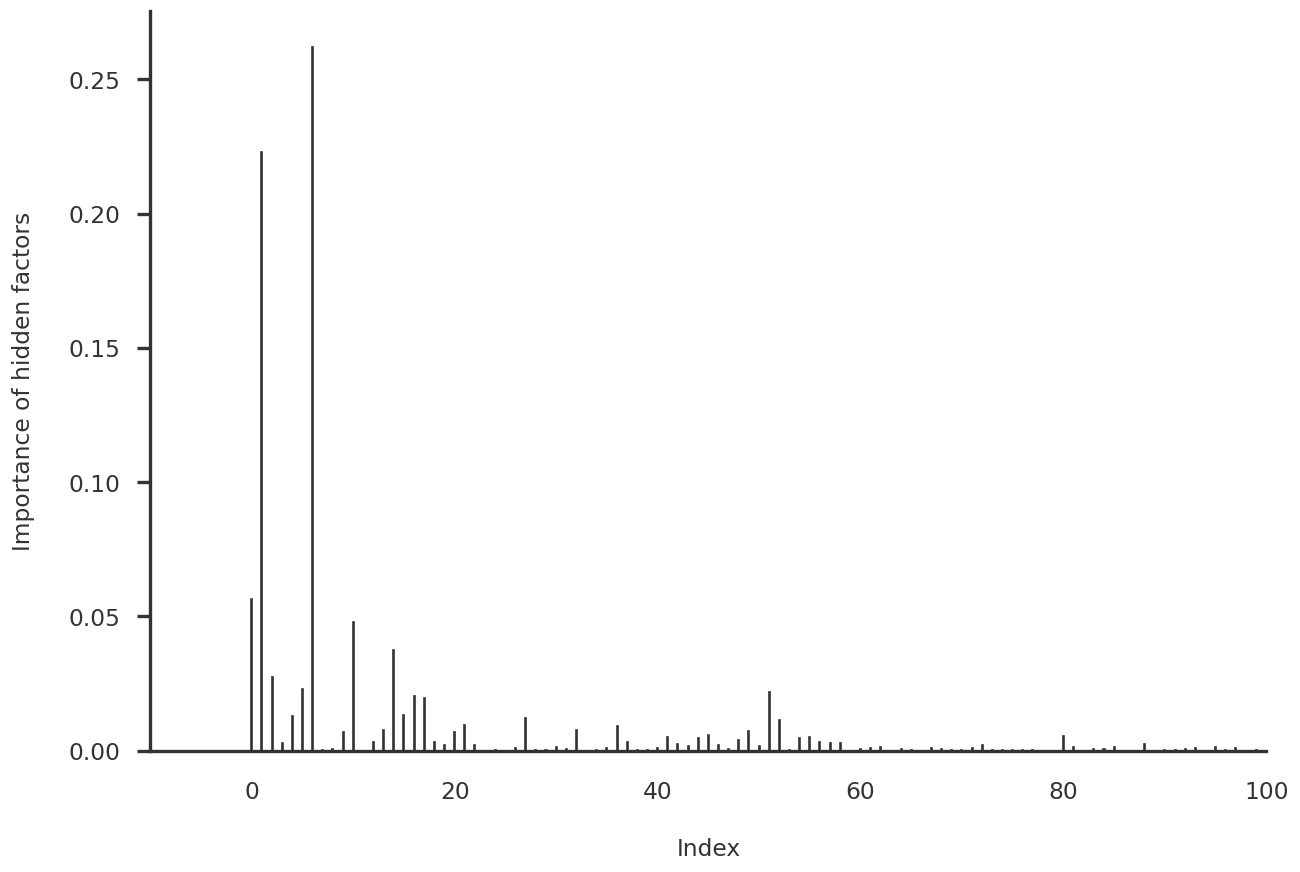

In [11]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(111)

xvals = np.arange(cos2_pheno.shape[0])
yvals = cos2_pheno[tidx,:]
ax1.bar(xvals, yvals, align = 'center', width = 0.1)

for side in ['top', 'right']:
    ax1.spines[side].set_visible(False)
    
ax1.tick_params(bottom=False)
ax1.set_ylabel(f"Importance of hidden factors")
ax1.set_xlabel(f"Index")

ax1.set_xlim([-10, 100])

plt.show()

# Contribution of traits to the leading factor

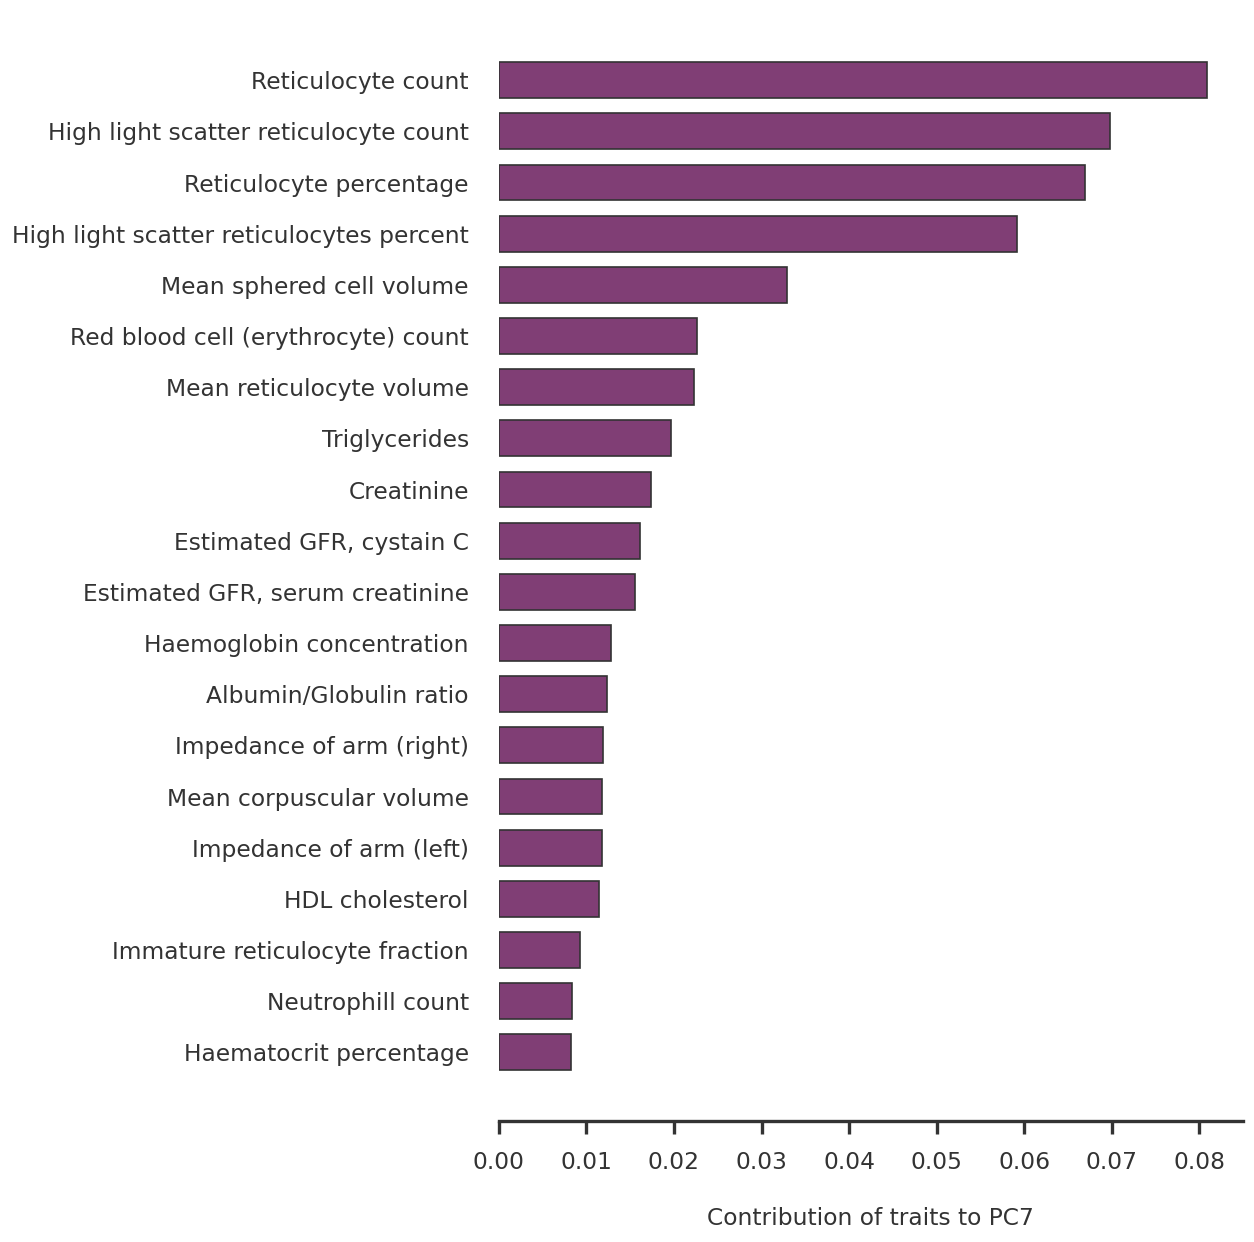

In [12]:
# cos2_pheno         = compute_cos(U)
# contribution_pheno = compute_contribution(U)
# cos2_pheno         = get_cos2_scores(loadings)
# contribution_pheno = get_contribution_scores(loadings)

fig = plt.figure(figsize = (8, 12))
ax1 = fig.add_subplot(111)

n_plot_traits = 20
xvals = top_traits_score[:n_plot_traits]
yvals = np.arange(n_plot_traits)[::-1]

ax1.barh(yvals, xvals, align = 'center', height = 0.7)
ax1.set_yticks(yvals)
ax1.set_yticklabels(top_traits_name[:n_plot_traits])

for side in ['top', 'right', 'left']:
    ax1.spines[side].set_visible(False)
    
ax1.tick_params(left=False)
ax1.set_xlabel(f"Contribution of traits to PC{top_factor + 1}")

plt.show()

We can look up which factors qualify as top factor for which disease.

In [13]:
top_factor_dict = {i : list() for i in range(cos2_pheno.shape[0])}
for i, trait_name in enumerate(trait_df_noRx['description'].to_list()):
    top_factor = np.argsort(cos2_pheno[i, :])[::-1][0]
    top_factor_dict[top_factor].append(trait_name)

In [65]:
top_factor_dict

{0: ['B98 Other specified infectious agents as the cause of diseases classified to other chapters',
  'D13 Benign neoplasm of other and ill-defined parts of digestive system',
  'E66 Obesity',
  'G93 Other disorders of brain',
  'J92 Pleural plaque',
  'K64 Haemorrhoids and perianal venous thrombosis',
  'M18 Arthrosis of first carpometacarpal joint',
  'N99 Postprocedural disorders of genito-urinary system, not elsewhere classified',
  'O04 Medical abortion',
  'O34 Maternal care for known or suspected abnormality of pelvic organs',
  'O47 False labour',
  'R09 Other symptoms and signs involving the circulatory and respiratory systems',
  'R45 Symptoms and signs involving emotional state',
  'R87 Abnormal findings in specimens from female genital organs',
  'W11 Fall on and from ladder',
  'X50 Overexertion and strenuous or repetitive movements',
  'X59 Exposure to unspecified factor',
  'Y42 Hormones and their synthetic substitutes and antagonists, not elsewhere classified',
  'Y45 A

# Contribution of variants to top factors

In [14]:
import requests
import json


def get_opentarget_score(gene_id):

    # Build query string to get association information
    query_string = """
        query TargetAssociationsQuery(
          $ensemblId: String!
          $filter: String
          $sortBy: String!
          $enableIndirect: Boolean!
        ) {
          target(ensemblId: $ensemblId) {
            id
            approvedSymbol
            associatedDiseases(
              orderByScore: $sortBy
              BFilter: $filter
              enableIndirect: $enableIndirect
            ) {
              count
              rows {
                disease {
                  id
                  name
                }
                score
              }
            }
          }
        }

    """

    # Set variables object of arguments to be passed to endpoint
    variables = {
        "ensemblId": gene_id, 
        "filter": focal_disease["opentarget_name"],
        "sortBy": "score",
        "enableIndirect": False
    }

    # Set base URL of GraphQL API endpoint
    base_url = "https://api.platform.opentargets.org/api/v4/graphql"
    # print (gene_id)

    # Perform POST request and check status code of response
    r = requests.post(base_url, json={"query": query_string, "variables": variables})
    # print(r.status_code)

    # Transform API response from JSON into Python dictionary and print in console
    api_response = json.loads(r.text)
    # print(api_response)

    score = 0.0
    if api_response['data']['target'] is not None:
        associated_diseases = api_response['data']['target']['associatedDiseases']['rows']
        for d in associated_diseases:
            if d['disease']['id'] == focal_disease["opentarget_id"]:
                score = d['score']
    # print(score)
    return score

def get_variant_names(df):
    vstr_list = list()
    for i in range(df.shape[0]):
        vstr = 'chr' + df.iloc[i][['chr', 'rsid', 'Gene_name']].astype('str').str.cat(sep=' | ')
        gene_id = df.iloc[i]['ensembl_gene_id']
        if not pd.isna(gene_id):
            assoc_score = get_opentarget_score(gene_id)
            vstr += f" | {assoc_score:.3f}"
        else:
            vstr += f" | NaN"
        vstr_list.append(vstr)
    return vstr_list

top_variant_names = get_variant_names(top_variant_df)

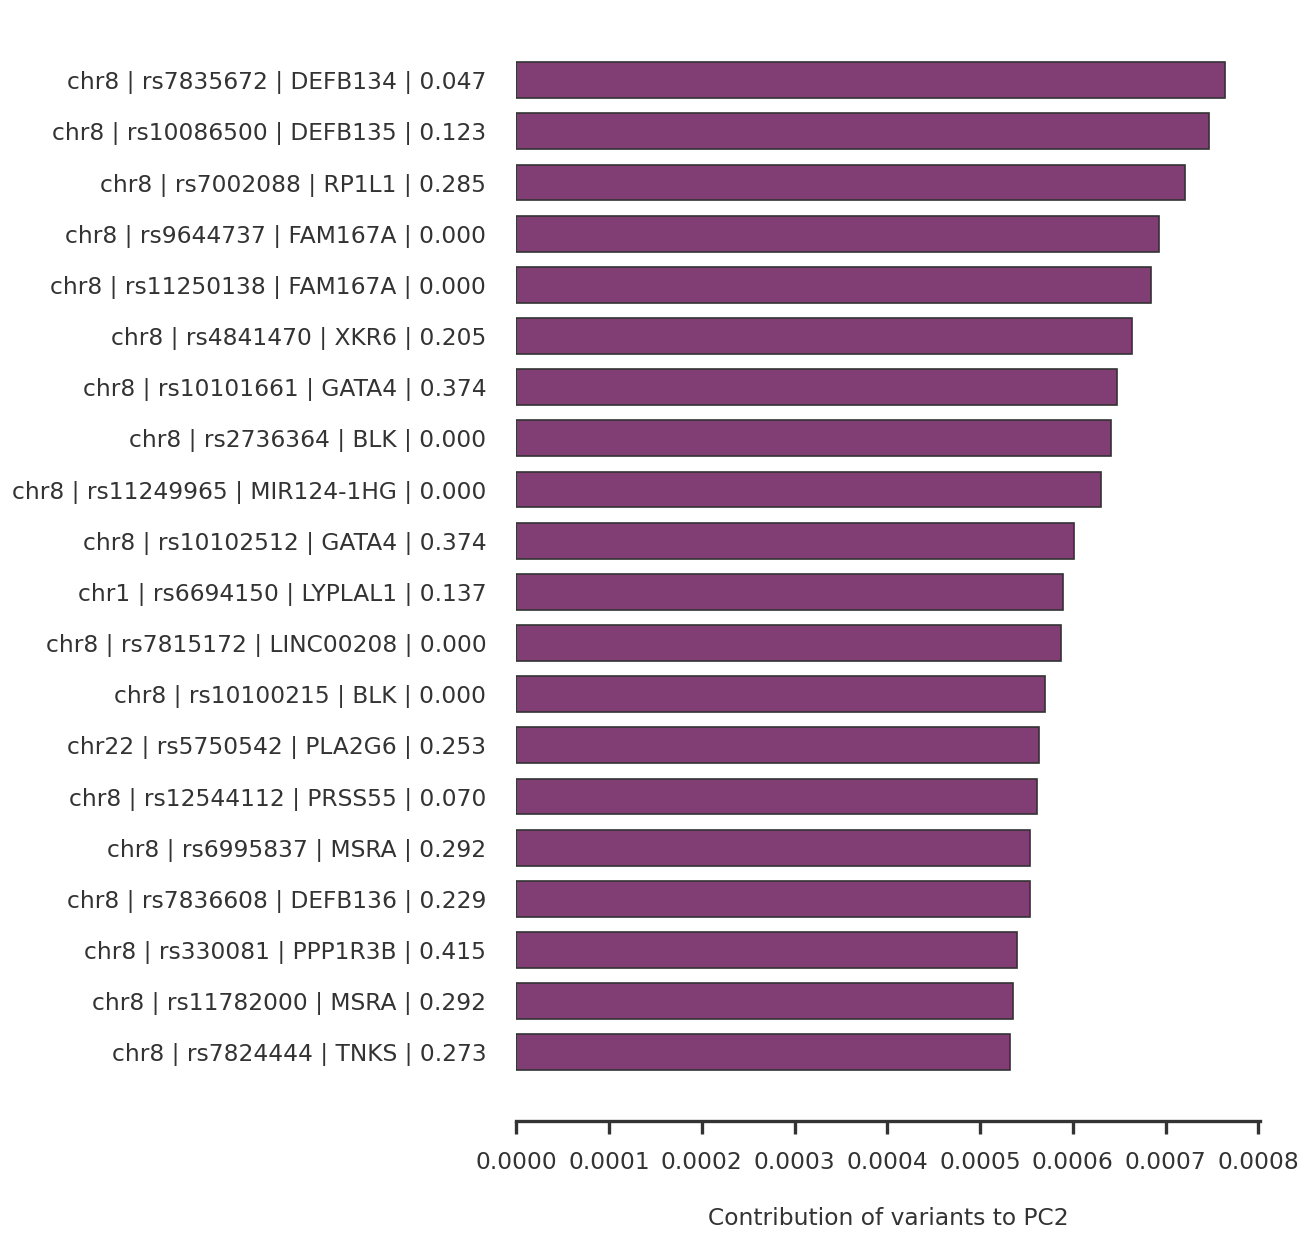

In [15]:
fig = plt.figure(figsize = (8, 12))
ax1 = fig.add_subplot(111)

n_plot_variants = 20
xvals = top_variant_score[:n_plot_traits]
yvals = np.arange(n_plot_traits)[::-1]

ax1.barh(yvals, xvals, align = 'center', height = 0.7)
ax1.set_yticks(yvals)
ax1.set_yticklabels(top_variant_names[:n_plot_traits])

for side in ['top', 'right', 'left']:
    ax1.spines[side].set_visible(False)
    
ax1.tick_params(left=False)
ax1.set_xlabel(f"Contribution of variants to PC{top_factor + 1}")

plt.show()

In [21]:
gene_id_array = variant_df['ensembl_gene_id'][~variant_df['ensembl_gene_id'].isna()].unique()

# all_assoc_scores = list()
# for gene_id in gene_id_array:
#     # print(gene_id)
#     all_assoc_scores.append(get_opentarget_score(gene_id))

# all_assoc_scores_arr = np.array(all_assoc_scores)
# np.save("/gpfs/commons/home/sbanerjee/work/npd/PanUKB/results/open_targets_triglycerides_assoc_scores_all_genes", all_assoc_scores_arr)
all_assoc_scores_arr = np.load("/gpfs/commons/home/sbanerjee/work/npd/PanUKB/results/open_targets_triglycerides_assoc_scores_all_genes.npy")

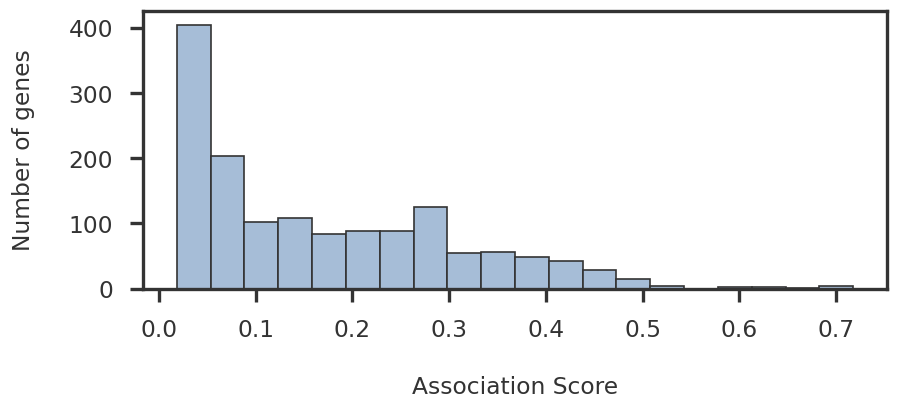

In [22]:
fig = plt.figure(figsize = (8, 3))
ax1 = fig.add_subplot(111)
ax1.hist(all_assoc_scores_arr[all_assoc_scores_arr > 0.01], color = '#A6BDD7')
ax1.set_xlabel("Association Score")
ax1.set_ylabel("Number of genes")
plt.show()

In [26]:
all_assoc_scores_arr.shape

(11546,)

In [23]:
np.where(np.array(all_assoc_scores) > 0)[0].shape

(1467,)

In [25]:
all_assoc_scores_arr[all_assoc_scores_arr > 0.05].shape

(1079,)